# Experiment 7 - Analysis

In [45]:
from glob import glob
from population.population import Population
import pandas as pd
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.myutils import load_dict, update_dict
from utils.dictionary import *
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as smm
from utils.myutils import load_dict
import seaborn as sns
from scipy.interpolate import make_interp_spline
from scipy.stats import kruskal, mannwhitneyu, ttest_ind, shapiro
from utils.dictionary import *
from scipy.interpolate import interp1d

In [46]:
# Hyperparameters
use_backup = True
populations = ['default', 'connection', 'gru_nr']
max_v = 50

In [48]:
# Parameters
FOLDER = f"population{'_backup' if use_backup else ''}/storage/experiment7/"
COLORS = [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2]]

## Load in the data

### Number of generations until solution

In [49]:
df_gens = pd.DataFrame()
for p in populations:
    gens = []
    for v in range(1, max_v+1):
        gens.append(len(glob(f'{FOLDER}{p}/v{v}/generations/gen_*')))
    df_gens[p] = gens

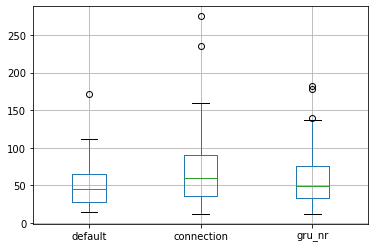

In [50]:
df_gens.boxplot()

### Found solution

In [51]:
%%capture
df_solutions = pd.DataFrame()
for p in populations:
    solutions = []
    for v in range(1, max_v+1):
        pop = Population(
                name=f'{p}/v{v}',
                folder_name='experiment7',
                use_backup=use_backup,
        )
        solutions.append(deepcopy(pop.best_genome))
    df_solutions[p] = solutions

In [52]:
def get_genome_params(g, pop_name):
    # Recurrent unit
    result = [b for b in g.nodes[2].bias_h]
    result += [w[0] for w in g.nodes[2].weight_xh]
    result += [w[0] for w in g.nodes[2].weight_hh]
    
    # Other parameters
    result += [g.connections[(-1, 1)].weight]
    if 'connection' not in pop_name: result += [g.connections[(-1, 2)].weight, g.connections[(2, 1)].weight]
    result += [g.nodes[1].bias]
    return result

In [53]:
def get_head(pop_name):
    head = []
    if 'gru_nr' in pop_name:
        head += ['bias_z', 'bias_h']
        head += ['weight_xz', 'weight_xh']
        head += ['weight_hz', 'weight_hh']
    else:
        head += ['bias_r', 'bias_z', 'bias_h']
        head += ['weight_xr', 'weight_xz', 'weight_xh']
        head += ['weight_hr', 'weight_hz', 'weight_hh']
        
    head += ['c0']
    if 'connection' not in pop_name: head += ['c1', 'c2']
    head += ['bias_rw']
    return head

In [54]:
def create_overview(pop_name):
    data = []
    for solution in df_solutions[pop_name].values:
        data.append(get_genome_params(solution, pop_name))
    df_default = pd.DataFrame(data, columns=get_head(pop_name))
    
    plt.figure(figsize=(20, 5))
    df_default.boxplot()
    plt.ylim(-6,6)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(15,5))
    for i, col in enumerate(df_default.columns):
        plt.subplot(int(len(df_default.columns)/5+1),5,i+1)
        sns.violinplot(df_default[col])
        plt.title(col)
        if 'bias' in col:
            plt.xlim(-3,3)
        else:
            plt.xlim(-6,6)
        plt.yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

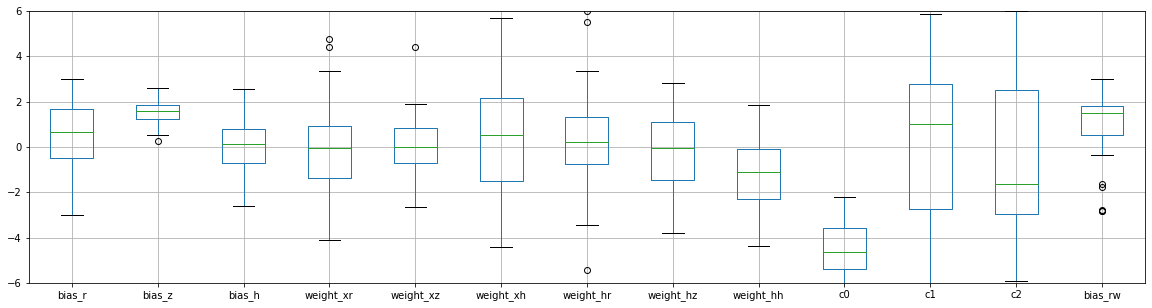

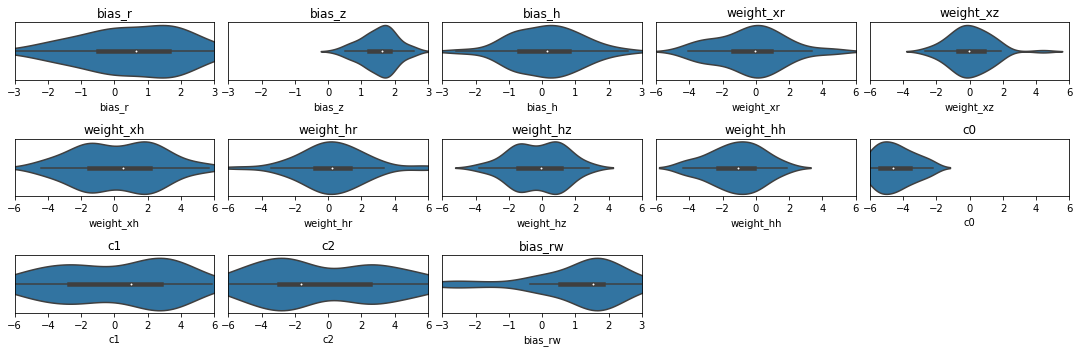

In [55]:
create_overview('default')

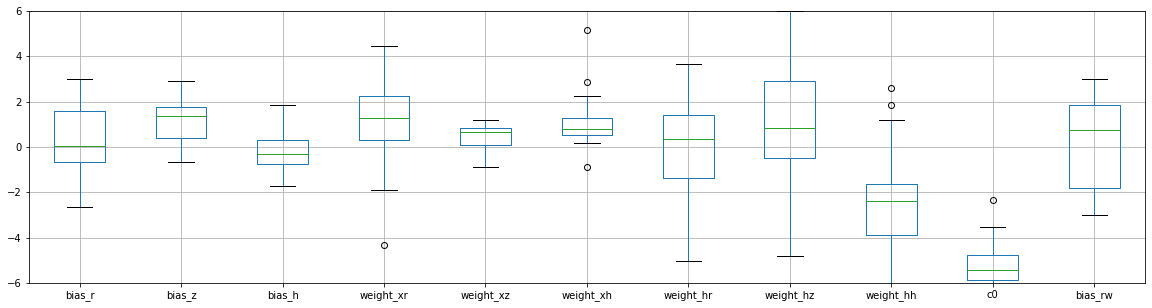

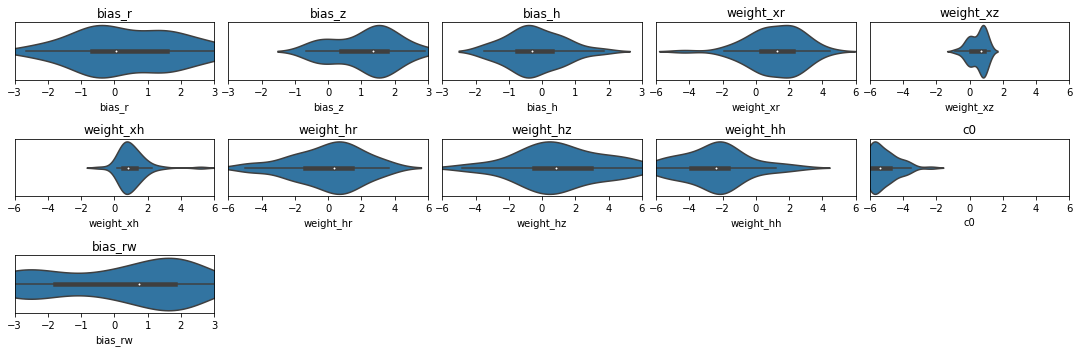

In [56]:
create_overview('connection')

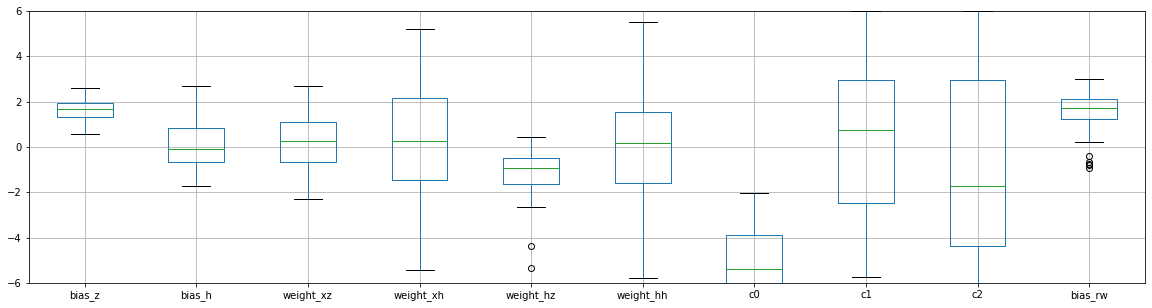

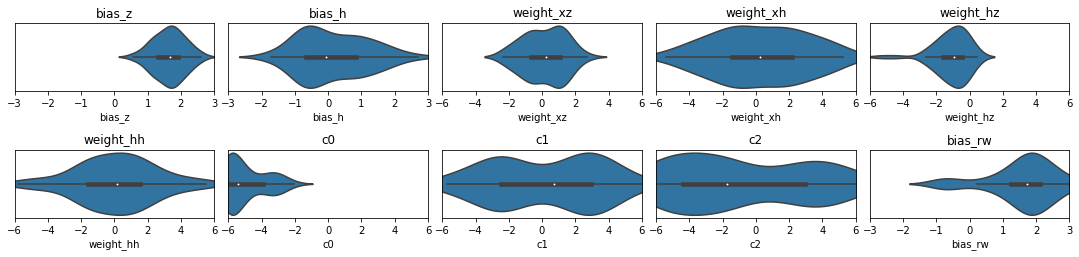

In [57]:
create_overview('gru_nr')

## Merge evaluation scores

NOTE: This part of the script assumes that `bash evaluation.bash` has run on each of the populations for every requested version.

### Collect the data

In [58]:
# 'default' population
data = []
for v in range(1, max_v+1):
    max_g = len(glob(f"{FOLDER}default/v{v}/evaluation/0*"))  # Assumption: no 10000 generations needed
    row = []
    for g in range(max_g):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}default/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FINISHED]/100 for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_default = pd.DataFrame(data).transpose()  # Rows indicate generations
df_default.columns = [v for v in range(1, max_v+1)]
df_default = df_default.fillna(1)  # nan values are those versions that already finished
df_default.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.0556,0.0556,0.0000,0.0556,0.0000,0.0000,0.0000,0.0000,0.1111,0.0000,...,0.0556,0.0000,0.1111,0.0556,0.0000,0.0000,0.0000,0.1111,0.0556,0.0556
1,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,...,0.0556,0.3889,0.2222,0.2222,0.2222,0.1667,0.2222,0.2222,0.2222,0.2222
2,0.2222,0.2222,0.2778,0.2222,0.1111,0.2222,0.2222,0.2778,0.2222,0.2222,...,0.2222,0.3889,0.1667,0.2222,0.2222,0.1667,0.2222,0.2222,0.4444,0.2222
3,0.2222,0.2222,0.3333,0.2222,0.2222,0.3333,0.2778,0.2778,0.2222,0.2222,...,0.2222,0.5000,0.1111,0.2222,0.2222,0.2222,0.2222,0.2222,0.5556,0.3333
4,0.1667,0.3333,0.3333,0.2222,0.2222,0.3333,0.2778,0.1667,0.2222,0.2222,...,0.2222,0.6111,0.1667,0.2222,0.2222,0.2222,0.2222,0.2222,0.5556,0.6667


In [59]:
# 'connection' population
data = []
for v in range(1, max_v+1):
    max_g = len(glob(f"{FOLDER}connection/v{v}/evaluation/0*"))  # Assumption: no 10000 generations needed
    row = []
    for g in range(max_g):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}connection/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FINISHED]/100 for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_connection = pd.DataFrame(data).transpose()  # Rows indicate generations
df_connection.columns = [v for v in range(1, max_v+1)]
df_connection = df_connection.fillna(1)  # nan values are those versions that already finished
df_connection.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.0556,0.0000,0.0000,0.0556,0.0556,0.0000,0.0000,0.0000,0.0556,0.0000,...,0.0556,0.0556,0.0000,0.1111,0.0556,0.0000,0.1111,0.0000,0.0000,0.0556
1,0.2778,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,...,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222
2,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,...,0.2222,0.2222,0.1111,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222
3,0.2778,0.0556,0.2222,0.2222,0.2222,0.2778,0.2222,0.2222,0.2222,0.2222,...,0.2222,0.1667,0.2222,0.2222,0.2222,0.2222,0.2222,0.2778,0.2222,0.2222
4,0.2778,0.1667,0.2778,0.1111,0.4444,0.2222,0.2222,0.2222,0.2222,0.2222,...,0.2222,0.1667,0.2778,0.2222,0.2778,0.2222,0.2222,0.2222,0.2222,0.2222


In [60]:
# 'gru_nr' population
data = []
for v in range(1, max_v+1):
    max_g = len(glob(f"{FOLDER}gru_nr/v{v}/evaluation/0*"))  # Assumption: no 10000 generations needed
    row = []
    for g in range(max_g):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}gru_nr/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FINISHED]/100 for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_gru_nr = pd.DataFrame(data).transpose()  # Rows indicate generations
df_gru_nr.columns = [v for v in range(1, max_v+1)]
df_gru_nr = df_gru_nr.fillna(1)  # nan values are those versions that already finished
df_gru_nr.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.0556,0.1111,0.0556,0.0556,0.0000,0.0556,0.0556,0.1111,0.0000,0.0000,...,0.1667,0.0556,0.0000,0.0000,0.0556,0.0000,0.0000,0.1111,0.0000,0.0000
1,0.1667,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,...,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.1667,0.2222,0.3333
2,0.2222,0.2222,0.2222,0.1111,0.2222,0.2222,0.2778,0.2222,0.3333,0.2222,...,0.2222,0.2778,0.3333,0.2222,0.2222,0.2222,0.3889,0.2222,0.2778,0.3333
3,0.3333,0.1667,0.2222,0.2222,0.2222,0.2222,0.2778,0.1667,0.2222,0.2222,...,0.2222,0.2778,0.3333,0.2778,0.1667,0.2778,0.3889,0.2778,0.2222,0.3333
4,0.3333,0.2222,0.2222,0.2222,0.2222,0.1667,0.2778,0.1667,0.3333,0.2222,...,0.1667,0.3333,0.2778,0.2222,0.2222,0.2778,0.3889,0.2222,0.2778,0.3889


### Visualize

Graph is similar to other experiments (work only in interquartile range), but now with finished ratio on y-axis and number of generations on x-axis.

In [62]:
plot_default = True
plot_connection = True
plot_gru_nr = True

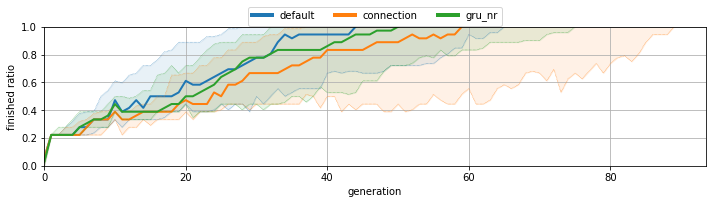

In [63]:
plt.figure(figsize=(10, 3))


### DEFAULT ###
if plot_default:
    c = 0
    # Get quantiles
    q1 = df_default.quantile(0.25, axis=1).values
    q2 = df_default.quantile(0.50, axis=1).values
    q3 = df_default.quantile(0.75, axis=1).values

    # Modify the lists
    q13_stop = np.where(q1 == 1)[0][0]
    q1 = q1[:q13_stop+1]
    q3 = q3[:q13_stop+1]
    q2_stop = np.where(q2 == 1)[0][0]
    q2 = q2[:q2_stop+1]

    # Plot
    plt.plot([i for i in range(len(q1))], 
             q1, 
             color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q3))], 
             q3, color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q2))], 
             q2, 
             color=COLORS[c], 
             linestyle="-", 
             linewidth=2, 
             label='default')
    plt.fill_between([i for i in range(len(q1))],
                     q1, 
                     q3,
                     color=COLORS[c], 
                     alpha=0.1)


### CONNECTION ###
if plot_connection:
    c = 1
    # Get quantiles
    q1 = df_connection.quantile(0.25, axis=1).values
    q2 = df_connection.quantile(0.50, axis=1).values
    q3 = df_connection.quantile(0.75, axis=1).values

    # Modify the lists
    q13_stop = np.where(q1 == 1)[0][0]
    q1 = q1[:q13_stop+1]
    q3 = q3[:q13_stop+1]
    q2_stop = np.where(q2 == 1)[0][0]
    q2 = q2[:q2_stop+1]

    # Plot
    plt.plot([i for i in range(len(q1))], 
             q1, 
             color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q3))], 
             q3, color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q2))], 
             q2, 
             color=COLORS[c], 
             linestyle="-", 
             linewidth=2, 
             label='connection')
    plt.fill_between([i for i in range(len(q1))],
                     q1, 
                     q3,
                     color=COLORS[c], 
                     alpha=0.1)


### GRU-NR ###
if plot_gru_nr:
    c = 2
    # Get quantiles
    q1 = df_gru_nr.quantile(0.25, axis=1).values
    q2 = df_gru_nr.quantile(0.50, axis=1).values
    q3 = df_gru_nr.quantile(0.75, axis=1).values

    # Modify the lists
    q13_stop = np.where(q1 == 1)[0][0]
    q1 = q1[:q13_stop+1]
    q3 = q3[:q13_stop+1]
    q2_stop = np.where(q2 == 1)[0][0]
    q2 = q2[:q2_stop+1]

    # Plot
    plt.plot([i for i in range(len(q1))], 
             q1, 
             color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q3))], 
             q3, color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q2))], 
             q2, 
             color=COLORS[c], 
             linestyle="-", 
             linewidth=2, 
             label='gru_nr')
    plt.fill_between([i for i in range(len(q1))],
                     q1, 
                     q3,
                     color=COLORS[c], 
                     alpha=0.1)


# Show the figure
leg = plt.legend(loc='upper center',
                 bbox_to_anchor=(0.5, 1.18),
                 fancybox=True,
                 fontsize=10,
                 ncol=len(populations))
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.xlabel("generation")
plt.xlim(0)
plt.ylabel('finished ratio')
plt.ylim(0, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(f"delete_me/experiment7.png", bbox_inches='tight', pad_inches=0.02)
# plt.savefig(f"delete_me/experiment7.eps", format="eps", bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

## Statistical analysis

In [64]:
df_gens.head()

,default,connection,gru_nr
0,23,127,139
1,171,31,44
2,77,160,48
3,40,77,45
4,22,20,137


In [65]:
Q1 = df_gens.quantile(0.25)
Q3 = df_gens.quantile(0.75)
IQR = Q3 - Q1
IQR

default       37.50
connection    54.25
gru_nr        42.25
dtype: float64

In [66]:
# Normaized dataframes (without any outliers)
df_n = df_gens[(df_gens >= (Q1 - 1.5 * IQR)) & (df_gens <= (Q3 + 1.5 * IQR))]

# Quantile dataframes (only values in the quantiles are kept)
# df_n = df[(df >= Q1) & (df <= Q3)]

df_n.head()

,default,connection,gru_nr
0,23.0,127.0,NaN
1,NaN,31.0,44.0
2,77.0,160.0,48.0
3,40.0,77.0,45.0
4,22.0,20.0,137.0


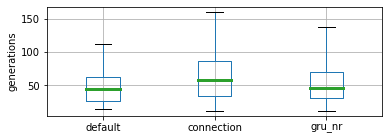

In [67]:
plt.figure(figsize=(6,2))
df_n.boxplot(whis=[0,100],  # Do not define outliers anymore
             medianprops={'linewidth':3})
plt.ylabel('generations')
#plt.savefig("temp_boxplot.png", bbox_inches='tight', pad_inches=0.02)
plt.savefig("delete_me/temp_boxplot.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

In [68]:
# Example of the Shapiro-Wilk Normality Test
for pop in populations:
    stat, p = shapiro(df_n[pop].dropna())
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print(f'{pop} is probably Gaussian (p={p:.5f})')
    else:
        print(f'{pop} is probably not Gaussian (p={p:.5f})')

stat=0.938, p=0.012
default is probably not Gaussian (p=0.01196)
stat=0.953, p=0.052
connection is probably Gaussian (p=0.05185)
stat=0.898, p=0.001
gru_nr is probably not Gaussian (p=0.00063)


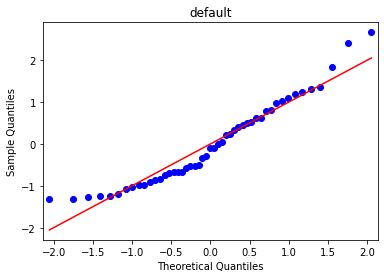

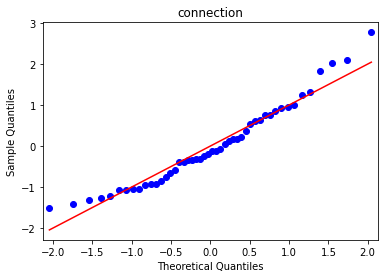

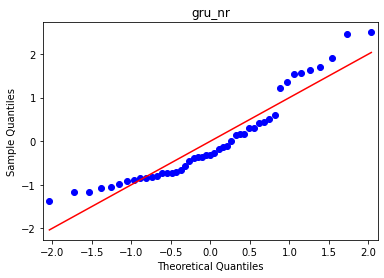

In [69]:
for p in populations:
    sm.qqplot(df_n[p].dropna(), line ='s', fit=True) 
    plt.title(p)
    plt.show() 

In [70]:
for i in range(len(populations)):
    pop1 = populations[i]
    for j in range(i+1, len(populations)):
        pop2 = populations[j]
        stat, p = mannwhitneyu(df_n[pop1].dropna(), 
                               df_n[pop2].dropna(), 
                               use_continuity=False, 
                               alternative='two-sided')
        print(f'{pop1} vs {pop2} -  p={p} - {"significant" if p < .05 else "insignificant"}')

default vs connection -  p=0.018107323612394505 - significant
default vs gru_nr -  p=0.23642959881574088 - insignificant
connection vs gru_nr -  p=0.28367758043677416 - insignificant
